#3. a VAE (variational autoencoder)
#Name: Saikiran Mamidala
#Student I'D: 500209412

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Conv2D, Conv2DTranspose, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.datasets import mnist

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = '/content/drive/My Drive/FaceExpressions.zip'  # Update with your ZIP file path


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()


In [ ]:
# Loading the dataset folder which has images
base_dir = 'dataset'
batch_size = 64
img_size = 128
seed_value=100

In [ ]:
training_set = tf.keras.utils.image_dataset_from_directory(
# Directory path
base_dir,
# No labels are needed
label_mode=None,
# Split 20% for validation
validation_split=0.2,
# Subset for training
subset="training",
# Seed for reproducibility
seed=100,
# Image dimensions
image_size=(img_size, img_size),
# Batch size
batch_size=batch_size,
# Color mode: RGB
color_mode='rgb'
)

Found 15453 files belonging to 1 classes.
Using 12363 files for training.


In [ ]:
validation_set = tf.keras.utils.image_dataset_from_directory(
# Directory path
base_dir,
label_mode=None,
# Split 20% for validation
validation_split=0.2,
# Subset for validation
subset="validation",
# Seed for reproducibility
seed=100,
# Image dimensions
image_size=(img_size, img_size),
# Batch size
batch_size=batch_size,
# Color mode: RGB
color_mode='rgb'
)

Found 15453 files belonging to 1 classes.
Using 3090 files for validation.


In [ ]:
# Normalization of img_pixels
training_set = training_set.map(lambda x: x / 255.0)
validation_set = validation_set.map(lambda x: x / 255.0)

In [ ]:
#Step 1: Encoding
from tensorflow.keras import backend as K
# Define latent dimension for the encoder
latent_dim = 2
# Define input shape for the encoder
input_shape = (img_size, img_size, 3)
# Define input layer for the encoder
inputs = Input(shape=input_shape, name='encoder_input')
# First convolutional layer with ReLU activation, 32 filters, stride 2, and same padding
x = Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(inputs)
# Second convolutional layer with ReLU activation, 64 filters, stride 2, and same padding
x = Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(x)
# Get shape before flattening for later use
shape_before_flattening = K.int_shape(x)
# Flatten the convolutional output
x = Flatten()(x)
# Dense layer to compute the mean of the latent space
z_mean = Dense(latent_dim)(x)
# Dense layer to compute the log variance of the latent space
z_log_var = Dense(latent_dim)(x)

In [ ]:
# defining Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.0)
    return z_mean + K.exp(z_log_var / 2) * epsilon
# Use Lambda layer to integrate sampling function into the model
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
# Initialize the model #1
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 32)           896       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 65536)                0         ['conv2d_1[0][0]']            
                                                                                            

In [ ]:
#Step 3: Decoder network
# Input layer for the decoder, sampling from latent space
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
# Fully connected layer to reshape into the shape before flattening
x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(latent_inputs)
# Reshape layer to match shape before flattening
x = Reshape(shape_before_flattening[1:])(x)
# Transposed convolutional layer with ReLU activation, 64 filters, stride 2, and same padding
x = Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same')(x)
# Transposed convolutional layer with ReLU activation, 32 filters, stride 2, and same padding
x = Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same')(x)
# Output layer with sigmoid activation for color images
outputs = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same', name='decoder_output')(x)
# Initialize the model #2
decoder = Model(latent_inputs, outputs, name='decoder')
# Print model summary
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 65536)             196608    
                                                                 
 reshape (Reshape)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 64, 64, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 128, 128, 32)      18464     
 Transpose)                                                      
                                                                 
 decoder_output (Conv2DTran  (None, 128, 128, 3)       867 

In [ ]:
#Ensure the encoder and decoder output shapes are equal
# VAE model
#Decode sampled latent vector (z) into reconstructed outputs
outputs = decoder(z)
# Initialize VAE
vae = Model(inputs, outputs, name='vae_mlp')
# Print a summary of the VAE model architecture
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 32)           896       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 65536)                0         ['conv2d_1[0][0]']            
                                                                                            

In [ ]:
# Custom layer for VAE loss calculation
class VAELossLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)
    def call(self, inputs):
        x, x_decoded_mean, z_mean, z_log_var = inputs
        # Calculate binary cross-entropy reconstruction loss
        decoded_img_loss = binary_crossentropy(K.flatten(x), K.flatten(x_decoded_mean))
        decoded_img_loss *= img_size * img_size * 3
        # Calculate KL divergence loss
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        # Calculate VAE loss as the mean of reconstruction loss and KL loss
        vae_loss = K.mean(decoded_img_loss + kl_loss)
        # Add VAE loss to the layer
        self.add_loss(vae_loss)
        # Return the decoded mean output
        return x_decoded_mean
# Instantiate the VAE loss layer with inputs
vae_outputs = VAELossLayer()([inputs, outputs, z_mean, z_log_var])
# Instantiate the VAE model with inputs and VAE loss outputs
vae = Model(inputs, vae_outputs, name='vae')
# Compile the VAE model with Adam optimizer
vae.compile(optimizer='adam')

In [ ]:

# Fit the VAE model
history = vae.fit(training_set, epochs=10, batch_size=batch_size, validation_data=validation_set)

Epoch 1/10
194/194 [==============================] - 75s 316ms/step - loss: 31297.0137 - val_loss: 30529.9492
Epoch 2/10
194/194 [==============================] - 56s 277ms/step - loss: 30490.1445 - val_loss: 30494.8926
Epoch 3/10
194/194 [==============================] - 55s 269ms/step - loss: 30468.4688 - val_loss: 30469.6641
Epoch 4/10
194/194 [==============================] - 65s 323ms/step - loss: 30451.5156 - val_loss: 30476.2227
Epoch 5/10
194/194 [==============================] - 55s 270ms/step - loss: 30440.8086 - val_loss: 30497.4336
Epoch 6/10
194/194 [==============================] - 55s 271ms/step - loss: 30435.2090 - val_loss: 30475.0000
Epoch 7/10
194/194 [==============================] - 54s 267ms/step - loss: 30425.8535 - val_loss: 30459.3027
Epoch 8/10
194/194 [==============================] - 55s 271ms/step - loss: 30420.6777 - val_loss: 30446.2910
Epoch 9/10
194/194 [==============================] - 65s 324ms/step - loss: 30413.2500 - val_loss: 30464.1816
E

2/2 [==============================] - 1s 6ms/step


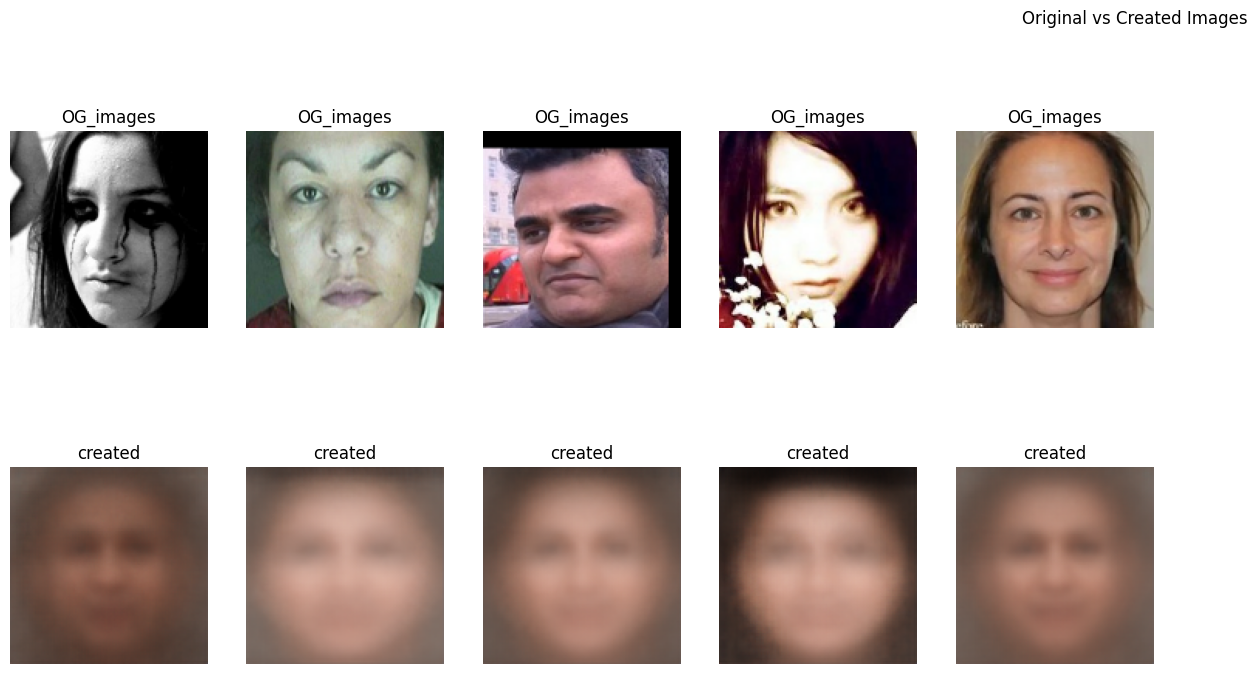

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import tensorflow as tf
# Take a batch of images from the validation set
for og_images in validation_set.take(10):
    display_img_config= (og_images.numpy() * 255).astype('uint8')
    z_mean, _, _ = encoder.predict(og_images)
    # predicting decoded images
    created_images = decoder.predict(z_mean)
    # Scaling the decoded images
    created_img_display = (created_images * 255).astype('uint8')
    plt.figure(figsize=(30, 8))

    for i in range(5):
        # Display Original images
        axes = plt.subplot(2, 10, i + 1)
        plt.imshow(display_img_config[i])
        plt.title("OG_images")
        plt.axis("off") #turn "on" to see the axis values
       # Display created images
        axes = plt.subplot(2, 10, i + 1 + 10)
        plt.imshow(created_img_display[i])
        plt.title("created")
        plt.axis("off") #turn "on" to see the axis values
    plt.suptitle("Original vs Created Images", fontsize=12, x=0.5, ha="center")
    plt.show()
    break

In [ ]:
# Generate images using the trained VAE
generated_images = vae.predict(validation_set)


49/49 [==============================] - 12s 211ms/step


In [ ]:
import pickle

# Assuming 'model' is your trained model
model = vae  # your trained model here

# Save the model to a file
filename = 'model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)

print(f"Model saved to {filename}")


Model saved to model.pkl


In [ ]:
from google.colab import files

# Download the file
files.download('model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.8 MB/s eta 0:00:00
